In [1]:
import subprocess
from pathlib import Path
import os

for file in os.listdir("Data"):
    if not file.endswith(".wav"):
        print(file)
        file_input = os.path.join("Data",file)
        file_output = os.path.join("Data", f"converted_{Path(file).suffix[1:]}_{Path(file).stem}.wav")
        subprocess.run(["ffmpeg", "-i", file_input, file_output])

240514 Subject 4.m4a
240515 Subject 5 labelled.xlsx
240515 Subject 5.mp3
240608 Subject 3 labelled.xlsx
data.rar
Valhacks_data


In [21]:
# waveform, sr = torchaudio.load("Data/converted_m4a_tester.wav") # this returns a tuple of the waveform and the sample rate

# spec = T.Spectrogram()(waveform)
# print(spec.shape)

# fig, axs = plt.subplots(2, 1)
# plot_waveform(waveform, sr, title="Original waveform", ax=axs[0])
# plot_spectrogram(spec[0], title="spectrogram", ax=axs[1])
# fig.tight_layout()

In [11]:
from torchaudio import transforms as T
from torchaudio import functional as F
import torchaudio
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import pandas as pd


def plot_waveform(waveform, sr, colors, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.scatter(time_axis, waveform[0], linewidth=1, c=colors)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)
    
def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    from librosa import power_to_db
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")

def get_spec(path):
    waveform, sr = torchaudio.load(path) # this returns a tuple of the waveform and the sample rate
    waveform_out = waveform[0]
    GROUPBY = sr//100 # 2 seconds

    spec = T.MFCC(sample_rate=sr, n_mfcc=80)(waveform_out)
    spec_out = spec[:,:spec.shape[1] // GROUPBY * GROUPBY].T
    spec_grouped = spec_out.reshape(-1, GROUPBY, spec_out.shape[1]).mean(axis=1)
    return spec_grouped

def kmeans_labels(spec, K):
    kc = KMeans(n_clusters=K, random_state=0, n_init="auto").fit(spec)
    centroids, labels = kc.cluster_centers_, kc.labels_
    return centroids, labels

def excel_conv(path):
    excel_labels = pd.read_excel(path)["Label phase 1"]
    # label_dict = {j:i for i,j in enumerate(excel_labels.unique())}
    label_dict = {
        "Nothing":0,
        "Crying":1,
        "Breathing":2,
        "Speaking/Babbling baby":3,
        "Speaking/Babbling Baby":3,
        "Speaking/voice Adult":4,
        "Other":5
    }
    excel_labels_converted = [label_dict[m] for m in excel_labels]
    return excel_labels_converted, label_dict

def knn_labels(x_train, y_train, x_test):
    from sklearn.neighbors import KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)
    return y_pred

In [38]:
path_sub3_wav = "Data/240528 Subject 3.wav"
path_sub3_xlsx = "Data/240608 Subject 3 labelled.xlsx"
path_sub5_wav = "Data/converted_mp3_240515 Subject 5.wav"
path_sub5_xlsx = "Data/240515 Subject 5 labelled.xlsx"

# spec_grouped1 = get_spec(path_sub3_wav)
spec_grouped2 = get_spec(path_sub5_wav)
# excel_labels1,label_dict1 = excel_conv(path_sub3_xlsx)
# excel_labels2,label_dict2 = excel_conv(path_sub5_xlsx)

centroids, k_labels = kmeans_labels(spec_grouped2, K=12)

c:\Users\alexa\AppData\Local\Programs\Python\Python39\lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [41]:
k_labels[k_labels == 0] # Noise 0
k_labels[k_labels == 3] = 0 # Noise 1
k_labels[k_labels == 7] = 0 # Noise 2
k_labels[k_labels == 11] = 0 # Noise 3
k_labels[k_labels == 10] = 0 # Noise 4 rustling?
k_labels[k_labels == 1] = 0 # Noise 5 rustling?
k_labels[k_labels == 6] = 0 # Cry related noise

k_labels[k_labels == 5] = 1 # Breathing
k_labels[k_labels == 9] = 1 # Heavy Breath

k_labels[k_labels == 2] # Cry related
k_labels[k_labels == 4] = 2 # Cry related
k_labels[k_labels == 8] = 2 # Scream

In [28]:
path_sub4_wav = "Data/converted_m4a_240514 Subject 4.wav"
path_sub4_wav = "Data/240519 0500 Subject 1.wav"
path_sub4_wav = "Data/240516 Subject 4-2.wav"
spec_grouped3 = get_spec(path_sub4_wav)

c:\Users\alexa\AppData\Local\Programs\Python\Python39\lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [39]:
x_test = spec_grouped2
x_train = spec_grouped2
y_train = k_labels
y_pred = y_train#knn_labels(x_train, y_train, x_test)

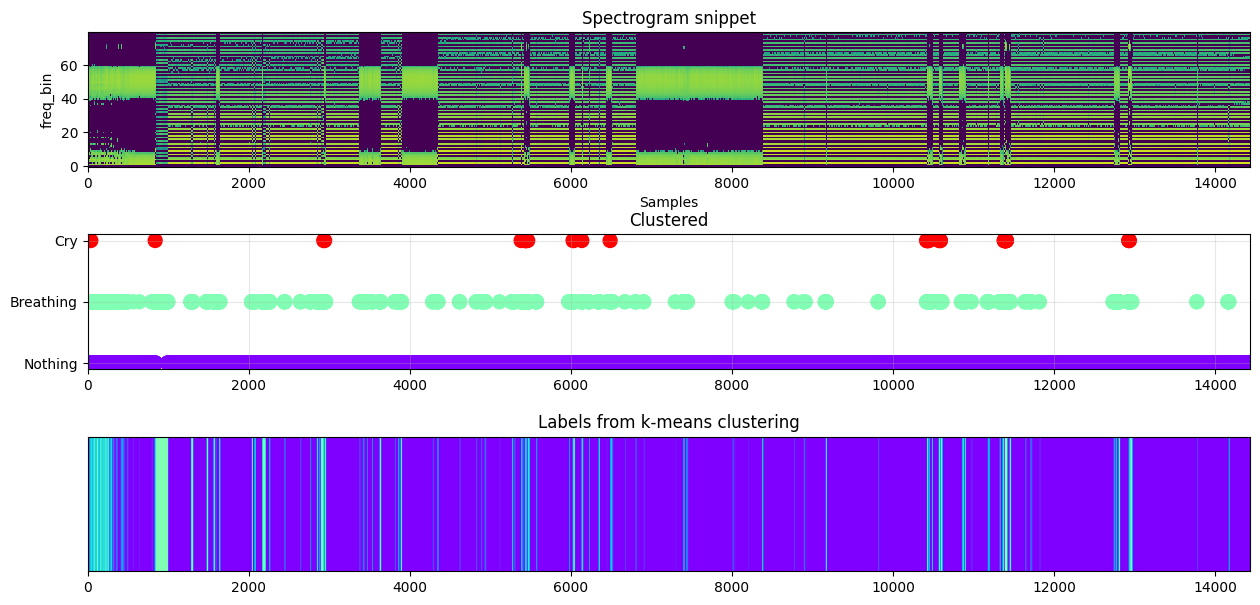

In [70]:
fig, axs = plt.subplots(3, 1)
fig.set_figheight(7)
fig.set_figwidth(15)
fig.subplots_adjust(hspace=.5)
xlim = None
# xlim = (0, 850)
# xlim = (5375, 5480)

i = 0
axs[i].set_title("Spectrogram snippet")
plot_spectrogram(x_test.T, ax=axs[i])
xlim = axs[i].get_xlim() if xlim is None else xlim
axs[i].set_xlim(xlim)
axs[i].set_xlabel("Samples")
i+=1

# axs[1].set_title("Labelled")
# axs[1].scatter(range(len(y_train)), y_train, c=y_train);
# axs[1].set_xlim(xlim)

# axs[2].set_title("Predicted")
# axs[2].scatter(range(len(y_comb)), y_comb, c=y_comb);
# axs[2].set_xlim(xlim)
axs[i].set_title("Clustered")
# big marker:
axs[i].scatter(range(len(y_pred)), y_pred, c=y_pred, cmap="rainbow", s=100);
axs[i].set_xlim(xlim)
# axs[i].set_xlabel("Samples")
axs[i].set_yticks(range(3), ["Nothing", "Breathing", "Cry"])#np.unique(y_pred))
axs[i].grid(True, alpha=0.3)
i+=1

# remove y ticks:
axs[i].set_yticks([])
axs[i].set_title("Labels from k-means clustering")
axs[i].imshow(y_pred[np.newaxis,:], cmap="rainbow", aspect="auto")
axs[i].set_xlim(xlim)
i += 1


def get_time(x):
    num1 = (x*2)/60/60
    num2 = (num1 % 1)*60
    num3 = (num2 % 1)*60
    return (np.array([num1,num2,num3],dtype=float)//1)

# set x ticks to time:
# time = get_time(np.arange(len(k_labels)))[1]

In [48]:
waveform, sr = torchaudio.load(path_sub5_wav)

(0.0, 0.01)

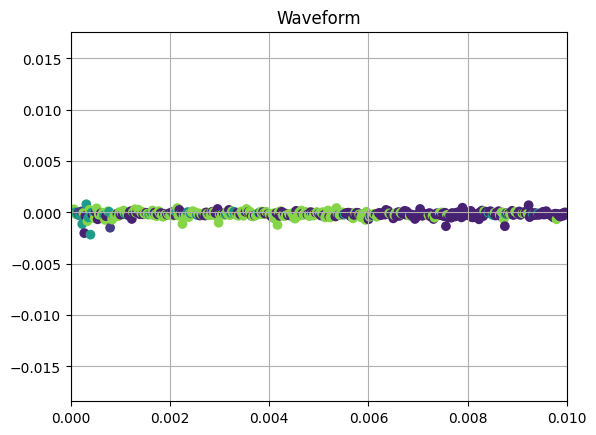

In [80]:
fig, axs = plt.subplots(1, 1)
plot_waveform(waveform[:,::sr*2][:,:-1], sr, colors=k_labels, ax=axs)
axs.set_xlim((0,0.01))